In [54]:
import numpy as np
# todo : 1 go from models to margins
# 2 compute KLOM from margins
from pathlib import Path
import torch as ch
from unlearning.unlearning_algos.utils import get_margins
from unlearning.datasets.cifar10 import get_cifar_dataloader
from unlearning.datasets.living17 import get_living17_dataloader
from unlearning.unlearning_algos import utils
from importlib import reload    
reload(utils)

from unlearning import LIVING17_ROOT
import os 

DATASET = "CIFAR10"
DATASET = "LIVING17"

if DATASET == "CIFAR10":
    dataloader = get_cifar_dataloader(num_workers=2, indexed=True)
    targets = dataloader.dataset.original_dataset.targets
    train_size = 50_000
    val_size = 10_000
    train_targets = targets[:train_size]
    val_targets = targets[train_size:train_size+val_size]
    
elif DATASET == "LIVING17":
    print("LIVING17")
    split = "train"
    TRAIN_TENSORS_PATH = "raw_tensors_tr_new.pt"
    VAL_TENSORS_PATH = "raw_tensors_val_new.pt"
    train_raw_tensors = ch.load(
        os.path.join(LIVING17_ROOT, TRAIN_TENSORS_PATH)
    )
    val_raw_tensors = ch.load(
        os.path.join(LIVING17_ROOT, VAL_TENSORS_PATH)
    )
    print(f"loading train raw tensors")
    dataloader = get_living17_dataloader(raw_tensors=train_raw_tensors, num_workers=2, indexed=True)
    train_targets = dataloader.dataset.dataset.original_dataset.tensors[1]
    train_targets = [int(t) for t in train_targets]
    print(f"loading val raw tensors")
    dataloader = get_living17_dataloader(raw_tensors=val_raw_tensors, num_workers=2, indexed=True)
    val_targets = dataloader.dataset.dataset.original_dataset.tensors[1]
    val_targets = [int(t) for t in val_targets]

    targets = train_targets + val_targets
    print(f"targets: {len(targets)}")
    print(len(set(targets)))
    train_targets = ch.tensor(train_targets)
    val_targets = ch.tensor(val_targets)
    targets = ch.tensor(targets)
PRECOMPUTE_DIR =Path("/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models")

BASE_ORACLE_MODELS = PRECOMPUTE_DIR / f"oracle_models/{DATASET}/"

FULL_MODELS = PRECOMPUTE_DIR / "full_models" / DATASET 



fid = 1
ORACLE_MODELS = BASE_ORACLE_MODELS/ f"forget_set_{fid}"
# list number of models in each dir
print(f"Number of models in {ORACLE_MODELS}:\n {len(list(ORACLE_MODELS.glob('*.pt')))}")
print(f"Number of models in {FULL_MODELS}:\n {len(list(FULL_MODELS.glob('*.pt')))}")

LIVING17
loading train raw tensors
loading val raw tensors
targets: 47600
17
Number of models in /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/LIVING17/forget_set_1:
 389
Number of models in /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/full_models/LIVING17:
 1004


/n/home04/rrinberg/venv_unlearning_bench/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [50]:
all_margins_path = FULL_MODELS / "train_margins_all.pt"
# train_logits_all.pt  train_margins_all.pt 
# val_logits_all.pt  val_margins_all.pt

all_margins = ch.load(all_margins_path)
all_margins.shape

torch.Size([200, 44200])

In [55]:
# we want to do 3 things
# 1. get all the logits for the train set, and save that
# 2. get all the logits for the val set, and save that
# 3. use 1 and 2 to compute margins for each point
# 4. compute KLOM for the oracles and the original model


def sort_train_logit_files(file_paths):
    """
    Sort validation logit files based on the number in the filename.
    Handles numeric sorting correctly (e.g., val_logits_4.pt < val_logits_5.pt < val_logits_49.pt)
    
    Args:
        file_paths: List of Path objects or strings containing filenames like "val_logits_237.pt"
        
    Returns:
        Sorted list of file paths
    """
    def get_val_number(filename):
        # Convert Path to string if needed
        filename = str(filename)
        num = int(filename.split('train_logits_')[1].split('.')[0])
        return num
    
    return sorted(file_paths, key=get_val_number)


def sort_val_logit_files(file_paths):
    """
    Sort validation logit files based on the number in the filename.
    Handles numeric sorting correctly (e.g., val_logits_4.pt < val_logits_5.pt < val_logits_49.pt)
    
    Args:
        file_paths: List of Path objects or strings containing filenames like "val_logits_237.pt"
        
    Returns:
        Sorted list of file paths
    """
    def get_val_number(filename):
        # Convert Path to string if needed
        filename = str(filename)
        # Extract number after 'val_logits_'
        num = int(filename.split('val_logits_')[1].split('.')[0])
        return num
    
    return sorted(file_paths, key=get_val_number)


def sort_by_first_number(path):
    """
    Sort paths by the first number in the filename in a natural way.
    For example: 1__val_logits__23.pt < 10__val_logits__23.pt < 11__val_logits__23.pt
    
    Args:
        path: Path object or string containing filename like "137__val_logits__23.pt"
        
    Returns:
        Integer value of the first number in the filename
    """
    # Convert Path to string if needed
    filename = str(path.name if hasattr(path, 'name') else path)
    # Extract first number before '__'
    first_num = int(filename.split('__')[0])
    return first_num

forget_set_id = 2

ALT_SAVE_DIR =  BASE_ORACLE_MODELS / "only_margins"
ALT_SAVE_DIR.mkdir(parents=True, exist_ok=True)

if DATASET == "CIFAR10":
    max_forget_set_id = 10
else:
    max_forget_set_id = 4
    
SAVE = True
overwrite = False 


for forget_set_id in range(1, max_forget_set_id + 1):
    print(f"forget_set_id: {forget_set_id}")
    print("----")
    oracle_logit_paths = BASE_ORACLE_MODELS / f"forget_set_{forget_set_id}" 
    alt_save_path = ALT_SAVE_DIR / f"forget_set_{forget_set_id}"
    alt_save_path.mkdir(parents=True, exist_ok=True)
    #/ "*__val_logits_all.pt"
    print(f"logit_paths: {oracle_logit_paths}")
    #train_logit_paths = list(logit_paths.glob("*__train_logits__23.pt"))
    oracle_train_logit_paths = list(oracle_logit_paths.glob("train_logits_*.pt"))
    # sort
    oracle_train_logit_paths = sort_train_logit_files(oracle_train_logit_paths)
    print(f"oracle_train_logit_paths : {oracle_train_logit_paths[:4]}")
    
    oracle_val_logit_paths = list(oracle_logit_paths.glob("val_logits_*.pt"))
    
    oracle_val_margin_paths = list(oracle_logit_paths.glob("*__val_margins__23.npy"))
    oracle_val_margin_paths = sorted(oracle_val_margin_paths, key=sort_by_first_number)
    print(f"oracle train length : {len(oracle_train_logit_paths)}")
    print(f"length of oracle_val_logit_paths: {len(oracle_val_margin_paths)}")
    
    all_train_margins_path = oracle_logit_paths / "train_margins_all.pt"

    if (not all_train_margins_path.exists()) or overwrite:
        print(f"computing oracle train margins")
        oracle_train_margins = []
        print(f"will load {len(oracle_train_logit_paths)} train logits")
        for i, path in enumerate(oracle_train_logit_paths):
            
            if i % 50 ==0:
                print(f"loaded {i} train logits")  
                print(path.name)
            train_logit = ch.load(path)
            margins = utils.get_margins_from_logits(train_logit, train_targets)
            oracle_train_margins.append(margins)
            
            
        print(margins.shape)


        oracle_train_margins_stack = ch.cat(oracle_train_margins, dim=1).T
        print(oracle_train_margins_stack.shape)
        # save 
        
        if SAVE:    
            ch.save(oracle_train_margins_stack, all_train_margins_path)
            ch.save(oracle_train_margins_stack, alt_save_path / "train_margins_all.pt")
            print(f"saving {all_train_margins_path}")
    ##
    # Computing margins for original model
    ##
    print(f" -- loading oracle val margins")
    all_val_margins_path = oracle_logit_paths / "val_margins_all.pt"
    if (not all_val_margins_path.exists()) or overwrite:
        # get oracle val logits and stack them
        oracle_val_margins = []
        if len(oracle_val_margin_paths) > 0:
            for i, val_margin_path in enumerate(oracle_val_margin_paths):
                if i % 50 ==0:
                    print(f"loaded {i} val margins")
                
                # read np
                val_margin = ch.from_numpy(np.load(val_margin_path)).view(-1, 1)
                oracle_val_margins.append(val_margin)
        else:
            for i, val_logit_path in enumerate(oracle_val_logit_paths):
                
                val_logit = ch.load(val_logit_path)
                margins = utils.get_margins_from_logits(val_logit, val_targets)
                oracle_val_margins.append(margins)
                if i % 50 ==0:
                    print(f"loaded {i} val logits")  
                    print(val_logit_path.name)
                    print(f"val_logit shape : {val_logit.shape}; val_targets shape : {val_targets.shape}")
            
        oracle_val_margins_stack = ch.cat(oracle_val_margins, dim=1).T
        print(oracle_val_margins_stack.shape)
            # save 
        

        
        if SAVE:
            ch.save(oracle_val_margins_stack, all_val_margins_path)
            ch.save(oracle_val_margins_stack, alt_save_path / "val_margins_all.pt")
            print(f"saving {all_val_margins_path}")


forget_set_id: 1
----
logit_paths: /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/LIVING17/forget_set_1
oracle_train_logit_paths : [PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/LIVING17/forget_set_1/train_logits_0.pt'), PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/LIVING17/forget_set_1/train_logits_1.pt'), PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/LIVING17/forget_set_1/train_logits_2.pt'), PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/LIVING17/forget_set_1/train_logits_3.pt')]
oracle train length : 100
length of oracle_val_logit_paths: 0
 -- loading oracle val margins
loaded 0 val logits
val_logits_21.pt
val_logit shape : torch.Size([3400, 17]); val_targets shape : torch.Size([3400])
loaded 50 val logits
val_logits_46.pt
val_logit shape : torch.Size([3400, 17])

In [44]:
#oracle_val_margin_paths = 
list(oracle_logit_paths.glob("*__val_margins__23.npy"))
oracle_logit_paths

PosixPath('/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracle_models/LIVING17/forget_set_1')

In [39]:

oracle_train_margins_stack.shape

torch.Size([160, 50000])

In [40]:

def get_all_logits__original():
    # load `val_margins_all.pt`
    train_margins_path = FULL_MODELS  / "train_margins_all.pt"
    val_margins_path = FULL_MODELS / "val_margins_all.pt"
    train_margins = ch.load(train_margins_path)
    val_margins = ch.load(val_margins_path)
    return train_margins, val_margins

print("getting original logits")
original_train_margins, original_val_margins = get_all_logits__original()
print(f"shapes : {original_train_margins.shape}, {original_val_margins.shape}")

getting original logits
shapes : torch.Size([200, 50000]), torch.Size([200, 10000])


In [41]:
print(oracle_train_margins_stack.shape)
original_train_margins.shape


torch.Size([160, 50000])


torch.Size([200, 50000])

forget_set_path - /n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/forget_set_inds/CIFAR10/forget_set_2.npy


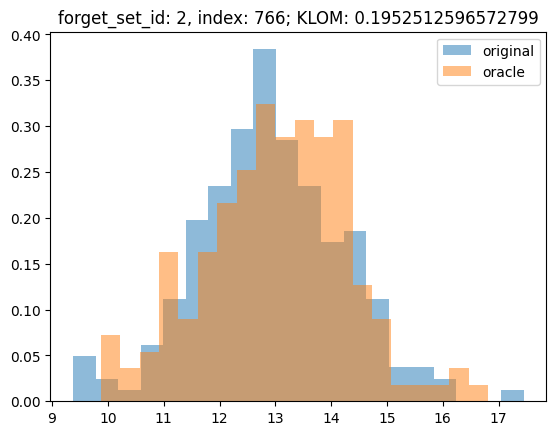

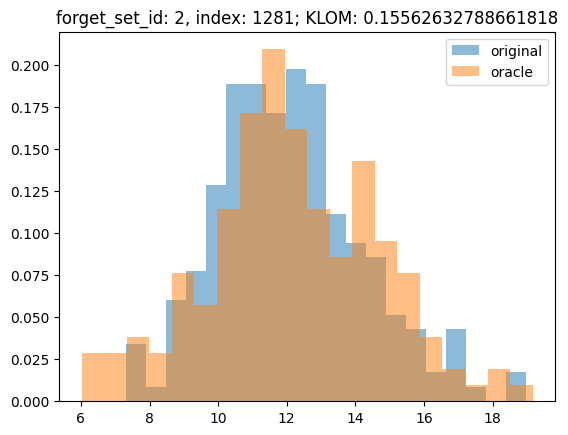

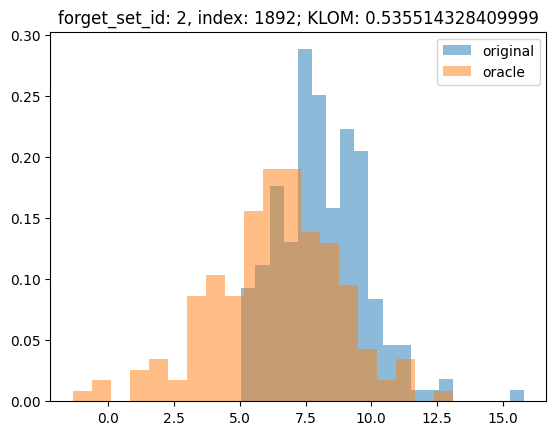

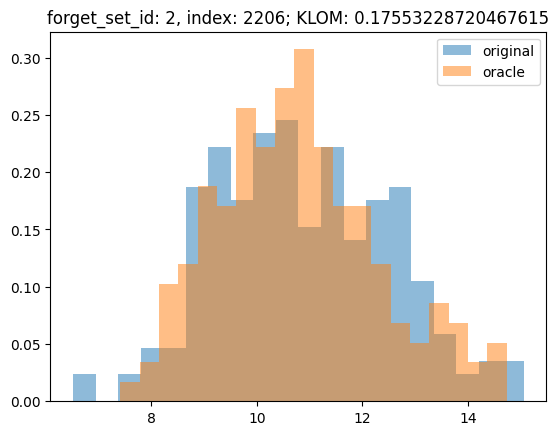

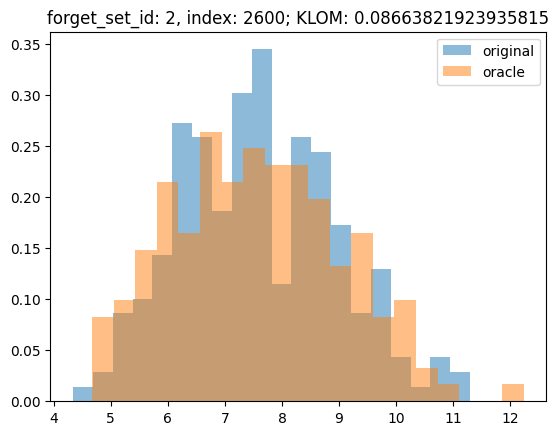

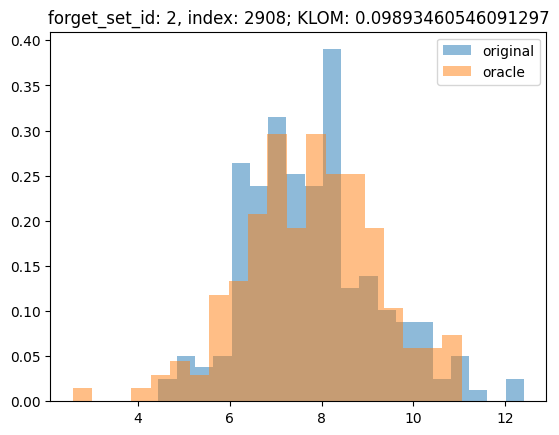

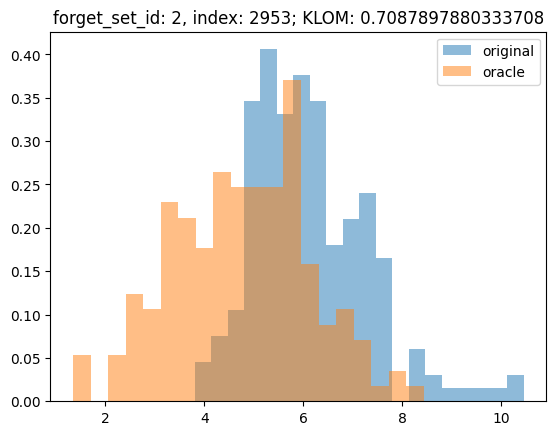

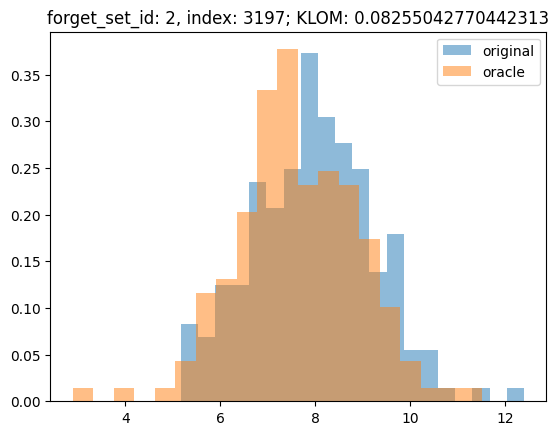

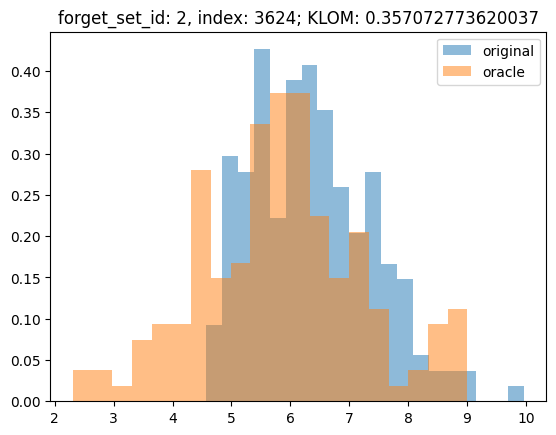

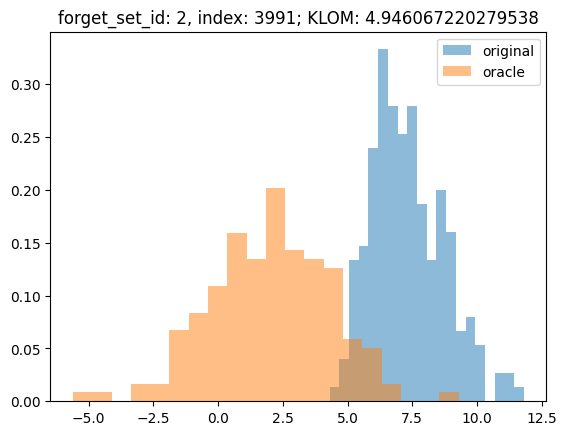

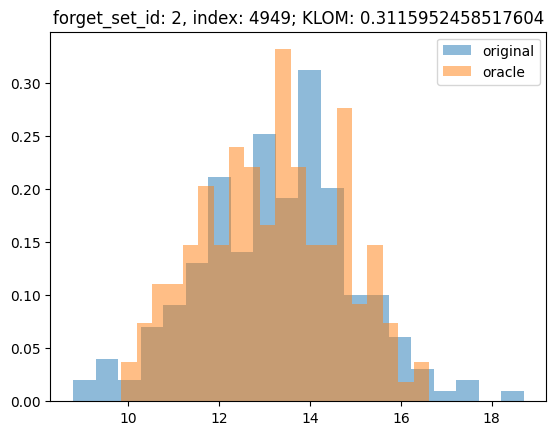

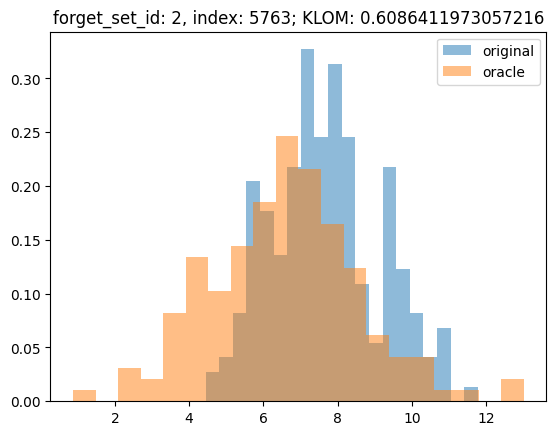

In [42]:
# forget_set_indices
from unlearning.auditors.utils import load_forget_set_indices
from unlearning.auditors import direct
import matplotlib.pyplot as plt
reload(direct)
forget_set_indices = load_forget_set_indices(DATASET, forget_set_id, DATA_DIR =PRECOMPUTE_DIR/ "forget_set_inds") 

print(forget_set_indices[:10])

for ii, index in enumerate(forget_set_indices):
    # plot histogram of margins 
    plt.hist(original_train_margins.T[index], bins=20, alpha=0.5, density =    True, label="original")
    #plt.hist(train_margins_stack.T[index], bins=20, alpha=0.5, density=True, label="oracle")
    plt.hist(oracle_train_margins_stack.T[index], bins=20, alpha=0.5, density=True, label="oracle")

    klom = direct.compute_binned_KL_div(original_train_margins.T[index], oracle_train_margins_stack.T[index])
    plt.legend()
    plt.title(f"forget_set_id: {forget_set_id}, index: {index}; KLOM: {klom[0]}")
    plt.show()
    if ii > 5:
        break





In [79]:
original_train_margins.T[3].shape

torch.Size([200])

In [ ]:
pt_index  = 10
oracle_train_logits.shape

# TODO - issue is likely the ordering
def gext_all_logits__oracle(forget_set_id, targets= targets, save = False):
    # collect all files of the form "*__train_logits__23.pt"
    logit_paths = BASE_ORACLE_MODELS / f"forget_set_{forget_set_id}" 
    #/ "*__val_logits_all.pt"
    print(f"logit_paths: {logit_paths}")
    train_logit_paths = list(logit_paths.glob("*__train_logits__23.pt"))
    train_margins = []
    print(f"loading {len(train_logit_paths)} train logits")
    for i, path in enumerate(train_logit_paths):
        if i % 10 ==0:
            print(f"loading {i} train logits")  
        train_logit = ch.load(path)
        margins = utils.get_margins_from_logits(train_logit, targets)
        
        train_margins.append(margins)
    print(f"single train_logits: {train_margins[0].shape}")
    print(f"number of train logits: {len(train_margins)}")
    
    
    
    val_logit_paths = list(logit_paths.glob("val_logits_*.pt"))
    val_logit_paths = sort_val_logit_files(val_logit_paths)
    val_logits = []
    print(f"loading {len(val_logit_paths)} val logits")
    for path in val_logit_paths:
        val_logits.append(ch.load(path))
    # to torch from list
    train_logits = ch.cat(train_logits)
    val_logits = ch.cat(val_logits)
    train_save_path = BASE_ORACLE_MODELS / "CIFAR10" / f"forget_set_{forget_set_id}" / "train_logits_all.pt"
    val_save_path = BASE_ORACLE_MODELS / "CIFAR10" / f"forget_set_{forget_set_id}" / "val_logits_all.pt"

    if save:
        print(f"saving")
        ch.save(ch.cat(train_logits), train_save_path)
        ch.save(ch.cat(val_logits), val_save_path)
    return train_logits, val_logits